# Symptom predictor baselines

We run some simple symptom predictor baselines on our SynSUM dataset. 

- BN-tab: Bayesian network trained to predict a symptom given other tabular features in the dataset. 
- XGBoost-tab: XGBoost classifier trained to predict a symptom given other tabular features in the dataset. 
- Neural-text: Neural classifier trained to predict a symptom given only text as an input. 
- Neural-text-tab: Neural classifier trained to predcit a symtpom, given the concatenation of text and tabular features at the input. 

For more information, we refer to the paper. 

We split the dataset into a train and test set, performing all our experiments on the same split. 

In [23]:
import sys
sys.path.append('../')

In [2]:
import pickle
with open("../data/df_synsum.p", "rb") as file: 
    df = pickle.load(file)

In [3]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=2024)

In [4]:
len(df_train), len(df_test)

(8000, 2000)

In [5]:
import pickle
with open("../data/df_train.p", "wb") as file: 
    pickle.dump(df_train, file)
with open("../data/df_test.p", "wb") as file: 
    pickle.dump(df_test, file)

## BN-tab 

We learn all parameters in the Bayesian network from the tabular portion of the training data. There are 4 types of distributions in the network, each defined by their own set of parameters: 
- Noisy OR (dysp, cough, pain, nasal)
- Conditional probability tables (policy, self_empl, asthma, smoking, COPD, winter, hay_fever, pneu, inf, fever)
- Logistic regression (antibiotics)
- Poisson regression (days at home)

The file "bayesian_network.py" contains the classes that implement all of these types of conditional distributions. Each distribution has a set of parameters that can be learned from the data. After we learn its parameters, we transform the distribution into a conditional probability table. These tables can be loaded into the Bayesian network functionality of the pgmpy library, which gives us access to the built-in Bayesian inference methods. 

### Noisy-OR

In [ ]:
import pickle
with open("../data/df_train.p", "rb") as file: 
    df_train = pickle.load(file)

In [2]:
CPTs = {}

In [3]:
from utils.bayesian_network import NoisyOr
import torch

parents = {"dysp": ["asthma", "smoking", "COPD", "hay_fever", "pneu"], 
           "cough": ["asthma", "smoking", "COPD", "pneu", "inf"], 
           "pain": ["COPD", "cough", "pneu", "inf"], 
           "nasal": ["hay_fever", "inf"]}

for symptom in ["dysp", "cough", "pain", "nasal"]: 
    torch.manual_seed(2023)
    model = NoisyOr(symptom, parents[symptom])
    model.train(df_train)
    CPTs[symptom] = model.get_CPT()

c:\Users\Paloma\Work\SynSUM\bayesian_network.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = {parent:torch.tensor(val) for parent, val in input.items()}
c:\Users\Paloma\Work\SynSUM\bayesian_network.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = {parent:torch.tensor(val) for parent, val in input.items()}
c:\Users\Paloma\Work\SynSUM\bayesian_network.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = {parent:torch.tensor(val) for parent, val in input.items()}
c:\Users\Paloma\Work\SynSUM\bayesian_networ

Example: CPT learned for symptom "nasal"

In [4]:
CPTs["nasal"] # ordering: [hay_fever=yes, inf=yes],[hay_fever=yes, inf=no],[hay_fever=no, inf=yes],[hay_fever=no, inf=no]

array([[0.96016   , 0.87174815, 0.71788067, 0.09180903],
       [0.03983998, 0.12825185, 0.28211933, 0.90819097]], dtype=float32)

### Antibiotics

In [5]:
from utils.bayesian_network import Antibiotics
import torch 

torch.manual_seed(2023)
model = Antibiotics("antibiotics", ["policy", "dysp", "cough", "pain", "fever"])
model.train(df_train)
CPTs["antibiotics"] = model.get_CPT()

c:\Users\Paloma\Work\SynSUM\bayesian_network.py:202: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = {parent:torch.tensor(val) for parent, val in input.items()}


In [6]:
CPTs["antibiotics"] # ordering: fever, policy, dysp, cough, pain (values always from high to low)

array([[0.9160996 , 0.853743  , 0.85330427, 0.7566731 , 0.83303124,
        0.7273134 , 0.7266168 , 0.58693147, 0.8144449 , 0.7011803 ,
        0.70044446, 0.5555658 , 0.6672835 , 0.5174165 , 0.5165401 ,
        0.36353695, 0.7336057 , 0.5955035 , 0.5946579 , 0.43955323,
        0.5571896 , 0.40216166, 0.40131816, 0.26382035, 0.52539164,
        0.37178287, 0.3709635 , 0.23970175, 0.33590952, 0.21285412,
        0.21226671, 0.12591772, 0.5274045 , 0.37367052, 0.3728495 ,
        0.24117623, 0.337713  , 0.21421003, 0.21361987, 0.126809  ,
        0.30968073, 0.19343509, 0.19288813, 0.11328851, 0.17011069,
        0.09876053, 0.0984486 , 0.05515819],
       [0.08390039, 0.14625698, 0.14669573, 0.2433269 , 0.16696876,
        0.2726866 , 0.2733832 , 0.41306853, 0.1855551 , 0.29881972,
        0.29955554, 0.44443423, 0.33271652, 0.48258352, 0.4834599 ,
        0.63646305, 0.26639432, 0.4044965 , 0.4053421 , 0.56044674,
        0.44281042, 0.59783834, 0.5986818 , 0.73617965, 0.47460836,
   

### Days at home

In [7]:
from utils.bayesian_network import DaysAtHome
import torch 

torch.manual_seed(2023)
model = DaysAtHome("days_at_home", ["antibiotics", "self_empl", "dysp", "cough", "pain", "nasal", "fever"])
model.train(df_train)
CPTs["days_at_home"] = model.get_CPT()

c:\Users\Paloma\Work\SynSUM\bayesian_network.py:311: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = {parent:torch.tensor(val) for parent, val in input.items()}


In [8]:
CPTs["days_at_home"] # ordering: fever, antibiotics, self_empl, dysp, cough, pain, nasal (values always from high to low)
                     # rows: 0 days, 1 days, 2 days, ..., 14 days, >= 15 days

array([[1.14047071e-02, 1.56522114e-02, 4.27800007e-02, ...,
        1.94828108e-01, 3.72160017e-01, 3.66029054e-01],
       [5.10215722e-02, 6.50684759e-02, 1.34829074e-01, ...,
        3.18668187e-01, 3.67854625e-01, 3.67874742e-01],
       [1.14128344e-01, 1.35249481e-01, 2.12469339e-01, ...,
        2.60612816e-01, 1.81799516e-01, 1.84864879e-01],
       ...,
       [5.26635093e-04, 2.78374704e-04, 2.07977173e-05, ...,
        1.87630533e-08, 5.13751819e-11, 6.27527058e-11],
       [1.68287545e-04, 8.26603791e-05, 4.68199278e-06, ...,
        2.19211227e-09, 3.62720791e-12, 4.50493852e-12],
       [6.87837601e-05, 3.07559967e-05, 1.31130219e-06, ...,
        0.00000000e+00, 0.00000000e+00, 1.19209290e-07]], dtype=float32)

In [9]:
CPTs["days_at_home"].shape

(16, 192)

### Conditional probability tables

We just use the built-in functionality of the pgmpy library to learn the conditional probability tables directly. 

In [10]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator

state_names = {"policy": ["yes", "no"], "self_empl": ["yes", "no"], "asthma": ["yes", "no"], "smoking": ["yes", "no"],
               "COPD": ["yes", "no"], "winter": ["yes", "no"], "hay_fever": ["yes", "no"], 
               "pneu": ["yes", "no"], "inf": ["yes", "no"], "fever": ["high", "low", "none"]}
BN_model = BayesianNetwork([("asthma", "pneu"), ("smoking", "COPD"), ("COPD", "pneu"),
                         ("winter", "pneu"), ("winter", "inf"), 
                         ("pneu", "fever"), ("inf", "fever")])
BN_model.add_node("hay_fever")
BN_model.add_node("policy")
BN_model.add_node("self_empl")

df_subset = df_train[["asthma", "pneu", "smoking", "COPD", "winter", "inf", "fever", "hay_fever", "policy", "self_empl"]]

BN_model.fit(df_subset, estimator=BayesianEstimator, prior_type="K2", state_names=state_names)

c:\Users\Paloma\anaconda3\envs\bn-text\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We now add in the other CPTs we learned, to fully specify the Bayesian network. 

In [11]:
BN_model.add_edges_from([("asthma", "dysp"), ("smoking", "dysp"), ("COPD", "dysp"), ("pneu", "dysp"), ("hay_fever", "dysp"),
                      ("asthma", "cough"), ("smoking", "cough"), ("COPD", "cough"), ("pneu", "cough"), ("inf", "cough"),
                      ("cough", "pain"), ("pneu", "pain"), ("COPD", "pain"), ("inf", "pain"), 
                      ("inf", "nasal"), ("hay_fever", "nasal")])

In [12]:
from pgmpy.factors.discrete import TabularCPD

cpd_dysp = TabularCPD(variable="dysp", variable_card=2, values = CPTs["dysp"],
                    evidence=["asthma", "smoking", "COPD", "hay_fever", "pneu"], evidence_card=[2, 2, 2, 2, 2],
                    state_names={"dysp":["yes", "no"], "asthma":["yes", "no"], "smoking":["yes", "no"], "COPD":["yes", "no"], "pneu":["yes", "no"], "hay_fever":["yes", "no"]})

cpd_cough = TabularCPD(variable="cough", variable_card=2, values = CPTs["cough"],
                    evidence=["asthma", "smoking", "COPD", "pneu", "inf"], evidence_card=[2, 2, 2, 2, 2],
                    state_names={"cough":["yes", "no"], "asthma":["yes", "no"], "smoking":["yes", "no"], "COPD":["yes", "no"], "pneu":["yes", "no"], "inf":["yes", "no"]})

cpd_pain = TabularCPD(variable="pain", variable_card=2, values = CPTs["pain"],
                    evidence=["COPD", "cough", "pneu", "inf"], evidence_card=[2, 2, 2, 2],
                    state_names={"pain":["yes", "no"], "COPD":["yes", "no"], "cough":["yes", "no"], "pneu":["yes", "no"], "inf":["yes", "no"]})

cpd_nasal = TabularCPD(variable="nasal", variable_card=2, values = CPTs["nasal"],
                    evidence=["hay_fever", "inf"], evidence_card=[2, 2],
                    state_names={"nasal":["yes", "no"], "hay_fever":["yes", "no"], "inf":["yes", "no"]})

In [13]:
BN_model.add_cpds(cpd_dysp, cpd_cough, cpd_pain, cpd_nasal)

In [14]:
BN_model.add_edges_from([("policy", "antibiotics"), ("dysp", "antibiotics"), ("cough", "antibiotics"), ("pain", "antibiotics"), ("fever", "antibiotics"),
                      ("antibiotics", "days_at_home"), ("dysp", "days_at_home"), ("cough", "days_at_home"), ("pain", "days_at_home"), ("fever", "days_at_home"), ("nasal", "days_at_home"), ("self_empl", "days_at_home")])

In [15]:
cpd_antibiotics = TabularCPD(variable="antibiotics", variable_card=2, values = CPTs["antibiotics"],
                    evidence=["fever", "policy", "dysp", "cough", "pain"], evidence_card=[3, 2, 2, 2, 2],
                    state_names={"antibiotics": ["yes", "no"], "fever":["high", "low", "none"], "policy":["yes", "no"], "dysp":["yes", "no"], "cough":["yes", "no"], "pain":["yes", "no"]})

cpd_days_at_home = TabularCPD(variable="days_at_home", variable_card=16, values = CPTs["days_at_home"],
                    evidence=["fever", "antibiotics", "self_empl", "dysp", "cough", "pain", "nasal"], evidence_card=[3, 2, 2, 2, 2, 2, 2],
                    state_names={"days_at_home": list([str(e) for e in range(15)])+[">=15"], "fever":["high", "low", "none"], "antibiotics":["yes", "no"], "self_empl":["yes", "no"], "dysp":["yes", "no"], "cough":["yes", "no"], "pain":["yes", "no"], "nasal":["yes", "no"]})

In [23]:
BN_model.add_cpds(cpd_antibiotics, cpd_days_at_home)

In [24]:
BN_model.nodes

NodeView(('asthma', 'pneu', 'smoking', 'COPD', 'winter', 'inf', 'fever', 'hay_fever', 'policy', 'self_empl', 'dysp', 'cough', 'pain', 'nasal', 'antibiotics', 'days_at_home'))

Now that the Bayesian network is fully specified, we can evaluate it. For each of the five symptoms, we predict the value using exact Bayesian inference, given a set of evidence nodes. We have three settings of evidence: 
- all: use all other variables as evidence
- no symptoms: use all other variables as evidence, except for other symptoms
- realistic: use all other variables as evidence, except for symptoms, policy, self-employed and days at home (since these would realistically not be encoded in a real patient record)

In [17]:
def predict_symptom(row, symptom, inf_obj, setting): 
    """
    Use the bayesian network to predict the probability of a symptom, given the values of the other variables in the evidence set
    row: row in the training or test dataframe, containing all values of tabular variables for this patient
    symptom: name of the symptom to predict
    inf_obj: inference object from pgmpy library (used to perform variable elimination)
    setting: evidence setting (all, no_sympt, realistic)
    """

    nodes = ["asthma", "smoking", "COPD", "pneu", "winter", "inf", "hay_fever", "dysp", "cough", "pain", "fever", "nasal", 
             "policy", "antibiotics", "days_at_home", "self_empl"]
    symptoms = ["dysp", "cough", "pain", "fever", "nasal"]

    if setting == "all": # all other tabular variables as evidence
        ev = {}
        for key in nodes: 
            if key != symptom: 
                ev[key] = row[key]

    elif setting == "no_sympt":
        ev = {}
        for key in nodes: 
            if key not in symptoms: 
                ev[key] = row[key]

    elif setting == "realistic": 
        ev = {}
        forbidden_keys = ["policy", "days_at_home", "self_empl"] + symptoms
        for key in nodes: 
            if key not in forbidden_keys: 
                ev[key] = row[key]

    else: 
        print("invalid setting")

    if symptom != "fever": # predict the probability P(symptom = yes | evidence)

        res = inf_obj.query([symptom], evidence=ev)
        prob = res.get_value(**{symptom:"yes"})

    elif symptom == "fever": # predict the probability P(fever = high | evidence), P(fever = low | evidence), P(fever = none | evidence)
        prob = []
        res = inf_obj.query([symptom], evidence=ev)
        for val in ["high", "low", "none"]: 
            prob.append(res.get_value(**{symptom:val}))
        return tuple(prob)

    return prob

In [18]:
import numpy as np
def label_fever(row): 
    """
    helper function which selects the most likely class for fever (high, low or none) from the predicted probabilities for each of these classes
    """
    max_idx = np.argmax((row["fever_prob_high"], row["fever_prob_low"], row["fever_prob_none"]))
    if max_idx == 0: 
        label = "high"
    elif max_idx == 1: 
        label = "low"
    else: 
        label = "none"
    return label

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
from pgmpy.inference.ExactInference import VariableElimination

def evaluate_BN(df, BN_model, setting): 
    """ 
    Evaluate the Bayesian network
    df: training or test dataframe
    BN_model: Bayesian network model, with conditional probability tables learned from the training data
    setting: evidence setting (all, no_sympt or realistic)
    """
    
    inf_obj = VariableElimination(BN_model) # inference object -> exact inference over learned BN_model using pgmpy library

    for sympt in ["dysp", "cough", "pain", "nasal"]:
        df[f"{sympt}_prob"] = df.apply(predict_symptom, axis=1, args=(sympt, inf_obj, setting)) # get predicted probability for each symptom
        df[f"{sympt}_pred"] = df[f"{sympt}_prob"].apply(lambda x: "yes" if x > 0.5 else "no") # get predicted label for each symptom (yes/no), threshold 0.5

    # do the same for symptom fever (which has three possible classes)
    df[["fever_prob_high", "fever_prob_low", "fever_prob_none"]] = df.apply(predict_symptom, axis=1, args=("fever", inf_obj, setting), result_type="expand")
    df["fever_pred"] = df.apply(label_fever, axis=1) # use helper function to get label of fever using argmax

    scores = pd.DataFrame(columns = ["precision", "recall", "f1", "accuracy"])

    # calculate precision, recall, F1, accuracy, from the predicted labels, comparing them with the ground-truth labels
    for sympt in ["dysp", "cough", "pain", "nasal"]: 
        prec = precision_score(df[sympt], df[f"{sympt}_pred"], pos_label="yes") 
        recall = recall_score(df[sympt], df[f"{sympt}_pred"], pos_label="yes")
        f1 = f1_score(df[sympt], df[f"{sympt}_pred"], pos_label="yes")
        acc = accuracy_score(df[sympt], df[f"{sympt}_pred"])
        scores.loc[sympt] = [prec, recall, f1, acc]

    # get macro metrics for fever 
    macro_precision = precision_score(df["fever"], df["fever_pred"], average='macro', labels=["none", "low", "high"])
    macro_recall = recall_score(df["fever"], df["fever_pred"], average='macro', labels=["none", "low", "high"])
    macro_f1 = f1_score(df["fever"], df["fever_pred"], average='macro', labels=["none", "low", "high"])
    macro_acc = accuracy_score(df["fever"], df["fever_pred"])
    scores.loc["fever"] = [macro_precision, macro_recall, macro_f1, macro_acc]

    return scores

We now evaluate the Bayesian network over the test dataframe. 

To be able to calculate the predictions for each patient in our dataset, we transform the values for the days_at_home variable into its corresponding categories known by the Bayesian network. 

In [26]:
def days_at_home_categories(val): 
    if val >= 15:
        return ">=15"
    else: 
        return str(val)
    
df_test["days_at_home_cat"] = df_test["days_at_home"].apply(days_at_home_categories)
df_test["days_at_home"] = df_test["days_at_home_cat"]
df_test = df_test.drop("days_at_home_cat", axis=1)

In [ ]:
import pickle
with open("../data/df_test.p", "rb") as file: 
    df_test = pickle.load(file)

In [27]:
scores = evaluate_BN(df_test, BN_model, setting="all")
print(scores)

       precision    recall        f1  accuracy
dysp    0.839744  0.656642  0.736990    0.9065
cough   0.742282  0.825373  0.781625    0.8455
pain    0.600000  0.148936  0.238636    0.8660
nasal   0.741597  0.689453  0.714575    0.8590
fever   0.737091  0.446921  0.486430    0.8045


In [28]:
scores = evaluate_BN(df_test, BN_model, setting="no_sympt")
print(scores)

       precision    recall        f1  accuracy
dysp    0.833333  0.626566  0.715308    0.9005
cough   0.731579  0.829851  0.777622    0.8410
pain    0.552632  0.074468  0.131250    0.8610
nasal   0.741597  0.689453  0.714575    0.8590
fever   0.744494  0.413652  0.438413    0.7965


In [29]:
scores = evaluate_BN(df_test, BN_model, setting="realistic")
print(scores)

       precision    recall        f1  accuracy
dysp    0.891667  0.536341  0.669797    0.8945
cough   0.728105  0.831343  0.776307    0.8395
pain    1.000000  0.014184  0.027972    0.8610
nasal   0.741597  0.689453  0.714575    0.8590
fever   0.532090  0.370917  0.359428    0.7840


c:\Users\Paloma\anaconda3\envs\bn-text\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## XGBoost-tab

We build an XGBoost classifier for each symptom and each setting (all, no_sympt, realistic). For each combination, we tune the hyperparameters using grid search, cross-validating over the training set with 5 folds. 

The function below, train_eval_XGBoost, performs both hyperparameter search, as well as training best model over the full train set. It also computes the test scores over the test set. 

In [ ]:
import pickle
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight

def train_eval_XGBoost(sympt, setting):

    seed = 2024
    scores = pd.DataFrame(columns = ["precision", "recall", "f1", "accuracy"])

    # import train and test set
    with open("../data/df_train.p", "rb") as file: 
        df_train = pickle.load(file)
    with open("../data/df_test.p", "rb") as file: 
        df_test = pickle.load(file)

    # select features according to setting
    features_realistic = ["asthma", "smoking", "COPD", "winter", "hay_fever", "pneu", "inf", "antibiotics"]
    symptoms = ["dysp", "cough", "pain", "fever", "nasal"]
    if setting == "all": 
        features = ["policy", "self_empl", "days_at_home"]+features_realistic+[s for s in symptoms if s != sympt]
    elif setting == "no_sympt": 
        features = ["policy", "self_empl", "days_at_home"]+features_realistic
    elif setting == "realistic": 
        features = features_realistic
    else: 
        print("invalid setting")
    print(features)
    X_train = df_train[features]
    y_train = df_train[sympt]
    X_test = df_test[features]
    y_test = df_test[sympt]

    # preprocessing
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), [f for f in features if f != "days_at_home"])
        ])

    # model pipeline
    if sympt == "fever": 
        xgb = XGBClassifier(objective="multi:softmax", num_class=3, eval_metric='mlogloss', random_state=seed) 
    else: 
        xgb = XGBClassifier(eval_metric='logloss', random_state=seed) 
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", xgb)])

    # hyperparameter search
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [2, 3, 4, 5],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__subsample': [0.8, 1],
        'classifier__colsample_bytree': [0.8, 1],
        'classifier__gamma': [0, 0.1, 0.3],
        'classifier__min_child_weight': [1, 5, 10]
    }
    if sympt != "fever": 
        ratio = sum(y_train==0)/sum(y_train==1)
        param_grid["classifier__scale_pos_weight"] = [ratio] # weight should be # negative samples / # positive samples
        f1_scorer = make_scorer(f1_score)
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=f1_scorer, verbose=1, n_jobs=-1)
        grid_search.fit(X_train, y_train)
    else: 
        sample_weights = compute_sample_weight(class_weight='balanced', y=y_train) # use sample weights to address unbalanced classes
        f1_scorer = make_scorer(f1_score, average="macro") # use macro for multiclass
        # random_search = RandomizedSearchCV(pipeline, param_grid, n_iter=n_comb, cv=5, scoring=f1_scorer, verbose=1, n_jobs=-1, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=f1_scorer, verbose=1, n_jobs=-1)
        grid_search.fit(X_train, y_train, classifier__sample_weight=sample_weights) 

    # best parameters and model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print("Best parameters found: ", best_params)

    # train scores (no need to fit on full train set, grid_search handles this automatically internally, so best_model is already retrained)
    if sympt == "fever": 
        avg_method = "macro"
    else:
        avg_method = "binary"
    y_train_pred = best_model.predict(X_train)
    print(y_train_pred[:20])
    print(y_train[:20])
    precision = precision_score(y_train, y_train_pred, average=avg_method)
    recall = recall_score(y_train, y_train_pred, average=avg_method)
    acc = accuracy_score(y_train, y_train_pred)
    f1 = f1_score(y_train, y_train_pred, average=avg_method)
    scores.loc["train"] = [precision, recall, f1, acc]

    # test scores
    if sympt == "fever": 
        avg_method = "macro"
    else:
        avg_method = "binary"
    y_test_pred = best_model.predict(X_test)
    precision = precision_score(y_test, y_test_pred, average=avg_method)
    recall = recall_score(y_test, y_test_pred, average=avg_method)
    acc = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred, average=avg_method)
    scores.loc["test"] = [precision, recall, f1, acc]

    return scores, best_model

We generate the results by running the hyperparameter search and model training for all the symptoms and settings, as shown below. The final results are not printed directly in the notebook, since we ran this in parallel on our HPC architecture. 

In [ ]:
n_comb = 1
full_scores_train = {}
full_scores_test = {}
for setting in ["all", "no_sympt", "realistic"]:
    scores_train = pd.DataFrame(columns = ["precision", "recall", "f1", "accuracy"])
    scores_test = pd.DataFrame(columns = ["precision", "recall", "f1", "accuracy"])
    for sympt in ["dysp", "cough", "pain", "fever", "nasal"]:
        res = train_eval_XGBoost(sympt, setting, n_comb)
        scores_train.loc[sympt] = res.loc["train"]
        scores_test.loc[sympt] = res.loc["test"]
    full_scores_train[setting] = scores_train
    full_scores_test[setting] = scores_test

The final results for each symptom and each setting over the test set can be found in "results/XGBoost_test.p".

In [31]:
with open("results/XGBoost_test.p", "rb") as file: 
    results = pickle.load(file)

In [33]:
results["all"]

,precision,recall,f1,accuracy
dysp,0.570144,0.794486,0.663874,0.8395
cough,0.710654,0.876119,0.784759,0.8390
pain,0.286541,0.702128,0.406989,0.7115
fever,0.402936,0.487631,0.411059,0.6435
nasal,0.735967,0.691406,0.712991,0.8575


In [35]:
results["no_sympt"]

,precision,recall,f1,accuracy
dysp,0.562390,0.802005,0.661157,0.8360
cough,0.703257,0.870149,0.777852,0.8335
pain,0.256151,0.627660,0.363823,0.6905
fever,0.392231,0.478116,0.401533,0.6500
nasal,0.741597,0.689453,0.714575,0.8590


In [36]:
results["realistic"]

,precision,recall,f1,accuracy
dysp,0.561955,0.807018,0.662551,0.8360
cough,0.703481,0.874627,0.779774,0.8345
pain,0.264036,0.617021,0.369819,0.7035
fever,0.381248,0.481450,0.395078,0.6530
nasal,0.741597,0.689453,0.714575,0.8590


## Neural-text

Our neural-text baseline takes only the text as an input, and predicts whether each symptom is mentioned in the text. We first split the text into sentences, and embed each sentence using the pretrained clinical language model BioLORD. We then combine the sentences into a single embedding, which is fed into a feed-forward neural network. The embeddings are static and not updated during training. To combine sentence embeddings into a single embedding per note, we consider 4 settings:
- hist: average all sentence embeddings in the "history" portion of the note
- phys: average all sentence embeddings in the "physical examination" portion of the note
- mean: to get a single representation of the full note, we take the average of the hist and phys embeddings
- concat: idem as previous, but we now concatenate the embeddings for the two portions

We train separate classifiers for each setting, starting from either the normal text or advanced text (8 models in total). 

### Split off history and physical examination

We first split each note up into a history portion and a physical examination portion. As shown in the example below, we can use the **History** and **Physical examination** headers for this. 

In [ ]:
import pickle
with open("../data/df_train.p", "rb") as file: 
    df_train = pickle.load(file)
with open("../data/df_test.p", "rb") as file: 
    df_test = pickle.load(file)

In [7]:
print(df_train.iloc[0]["text"])

**History**
Patient presents with generalized fatigue persisting for several weeks, significantly affecting daily activities. Reports adequate sleep but still feels unusually tired upon waking. Denies recent illness, significant stress, or changes in diet and exercise routine. Hydration and nutritional intake appear balanced.

**Physical Examination**
Vital signs: blood pressure 120/78 mmHg, pulse 70 bpm, temperature 98.6°F. Respiratory system clear upon auscultation, with no adventitious sounds. Cardiovascular exam with regular rhythm and no murmurs. Abdominal exam shows normal bowel sounds, no tenderness or organomegaly. Skin appears well-hydrated without signs of pallor or cyanosis.


In [8]:
def split_text(row, col_name):
    """
    Split the note into a "history" portion and a "physical examination" portion
    row: row of the dataframe (patient)
    col_name: col_name indicating the type of text ("text" for normal or "advanced_text" for compact)
    """
    text = row[col_name] 
    try: 
        text = text.split("**History**")[1]
        text = text.strip()
        text = text.split("**Physical Examination**")
        history = text[0].strip()
        phys_exam = text[1].strip()

        return history, phys_exam
    except:
        return "error", "error"

In a prior preprocessing phase, we ran the code below on all the texts in our dataset, to clean up inconsistent headers for the "history" and "physical examination" portions and ensure that we could correctly split the texts based on these headers. All the texts found in the dataframes in the "data" folder are already the cleaned versions. 

In [ ]:
def clean_text(row, col_name): 
    text = row[col_name] 
    text = text.replace("**History:**", "**History**")
    text = text.replace("**Hx**", "**History**")
    text = text.replace("**Hx:**", "**History**")
    text = text.replace("**HPI**", "**History**")
    text = text.replace("### History", "**History**")
    text = text.replace("**Physical Examination:**", "**Physical Examination**")
    text = text.replace("**PE**", "**Physical Examination**")
    text = text.replace("**PE:**", "**Physical Examination**")
    text = text.replace("**Physical Exam**", "**Physical Examination**")
    text = text.replace("**Physical Exam:**", "**Physical Examination**")
    text = text.replace("### Physical Examination", "**Physical Examination**")
    return text

We split up the notes (both normal and compact) into two parts (hist and phys_exam), for both the training set and the test set. 

In [9]:
df_train[["text_hist", "text_phys_exam"]] = df_train.apply(split_text, axis=1, args=("text",), result_type="expand")
df_test[["text_hist", "text_phys_exam"]] = df_test.apply(split_text, axis=1, args=("text",), result_type="expand")
df_train[["advanced_text_hist", "advanced_text_phys_exam"]] = df_train.apply(split_text, axis=1, args=("advanced_text",), result_type="expand")
df_test[["advanced_text_hist", "advanced_text_phys_exam"]] = df_test.apply(split_text, axis=1, args=("advanced_text",), result_type="expand")

### BioLORD embeddings

We now generate the hist and phys embeddings, storing them in the train and test dataframes. We use the BioLORD model, a pre-trained clinical sentence embedding model. We use mean-pooling to create one embedding over all the sentences in one section of the note.

In [10]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("FremyCompany/BioLORD-2023") # import the BioLORD model

In [11]:
import nltk
def get_embeddings(row): 

    print(row.name)

    # split into sentences
    text_hist = row["text_hist"]
    text_phys = row["text_phys_exam"]
    sent_hist = nltk.tokenize.sent_tokenize(text_hist)
    sent_phys = nltk.tokenize.sent_tokenize(text_phys)

    # encode history and physical examination portion
    enc_hist = model.encode(sent_hist, normalize_embeddings=True)
    enc_phys = model.encode(sent_phys, normalize_embeddings=True)

    # mean pool
    mean_enc_hist = enc_hist.mean(axis=0)
    mean_enc_phys = enc_phys.mean(axis=0)

    return mean_enc_hist, mean_enc_phys

By means of example, we generate the embeddings for the first 3 notes. 

In [13]:
subset = df_train.iloc[:3].copy()
subset[["hist_emb", "phys_emb"]] = subset.apply(get_embeddings, axis=1, result_type="expand")

8276
9288
530


In [14]:
subset.head()

,policy,self_empl,asthma,smoking,COPD,winter,hay_fever,pneu,inf,dysp,...,antibiotics,days_at_home,text,advanced_text,text_hist,text_phys_exam,advanced_text_hist,advanced_text_phys_exam,hist_emb,phys_emb
8276,yes,no,no,no,no,no,no,no,no,no,...,no,1,**History**\nPatient presents with generalized...,**History**\nPt reports generalized fatigue x ...,Patient presents with generalized fatigue pers...,"Vital signs: blood pressure 120/78 mmHg, pulse...",Pt reports generalized fatigue x several weeks...,"VS: BP 120/78, HR 70, Temp 98.6°F. Lungs: CTA ...","[0.018713936, 0.027707404, 0.025443545, -0.003...","[-0.034004696, 0.038478002, 0.016022738, 0.001..."
9288,no,yes,no,no,no,yes,no,no,yes,no,...,no,1,**History**\nPatient presents with complaints ...,"**History**\nPt c/o light, persistent cough an...","Patient presents with complaints of a light, p...","General: Patient appears alert and oriented, n...","Pt c/o light, persistent cough and scraping pa...","Gen: Alert, oriented, no acute distress.\nHEEN...","[2.1253845e-05, -0.000994858, 0.002572391, -0....","[-0.019426296, 0.01383667, 0.01292638, -0.0110..."
530,yes,no,no,no,no,yes,no,no,yes,no,...,yes,4,**History**\nThe patient presents with nasal s...,**History**\nPt presents w/ nasal Sx: congesti...,The patient presents with nasal symptoms inclu...,Vitals are stable. Examination of the nasal ca...,Pt presents w/ nasal Sx: congestion & rhinorrh...,"Vitals stable. Nasal cavity: mild erythema, sw...","[0.025020013, 0.008496902, -0.002807917, -0.03...","[-0.014379498, 0.04056057, -0.001898982, -0.00..."


The hist and phys embeddings for the entire train and test set are stored in "data/emb/df_train_emb_part1.p", "data/emb/df_train_emb_part2.p" and "data/emb/df_test_emb.p". We precompute these, since the sentence embedding model is quite slow and we are keeping the embeddings static anyway. The train dataframe is split in two, since github does not allow files bigger than 100MB.

In [15]:
import pickle
with open("../data/emb/df_train_emb.p", "rb") as file: 
    df_train = pickle.load(file) 

In [18]:
df_train_emb_part1 = df_train.iloc[:4000]

In [20]:
df_train_emb_part2 = df_train.iloc[4000:]

In [25]:
with open("../data/emb/df_train_emb_part1.p", "wb") as file: 
    pickle.dump(df_train_emb_part1, file)
with open("../data/emb/df_train_emb_part2.p", "wb") as file: 
    pickle.dump(df_train_emb_part2, file)

### Train neural classifier

The file "neural_classifier.py" contains the TextEmbClassifier class. We can use this class to build an MLP with a specified number of layers and their dimensions. The MLP takes an embedding at the input (size can be specified at initialization) and predicts a symptom at the output. 

The code below first transforms our dataframe into a Pytorch dataset. Each item in the dataset is a dictionary, containing the symptom label and the embedding, which is selected according to the setting (hist, phys, mean, concat) specified and the complexity (normal, advanced) of the note. 

In [11]:
import pickle
import pandas as pd

with open("../data/emb/df_train_emb_part1.p", "rb") as file: 
    df_train1 = pickle.load(file)
with open("../data/emb/df_train_emb_part2.p", "rb") as file: 
    df_train2 = pickle.load(file)

df_train = pd.concat([df_train1, df_train2]) # concatenate the two parts 

In [4]:
from torch.utils.data import random_split
from utils.neural_classifier import TabularTextDataset
import torch

symptom = "dysp"
setting = "hist" 
type = "normal"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = TabularTextDataset(df_train, "dysp", device, setting, type)

# split off train and validation set
train_data, val_data = random_split(dataset, [0.8, 0.2])

len(train_data), len(val_data)

(6400, 1600)

The dimension of the "hist" embedding type is 768. All other embedding types have the same dimension, except for concat, which is 2*768.

In [5]:
print(train_data.__getitem__(0)["dysp"]) # symptom label
print(train_data.__getitem__(0)["emb"][:10]) # first 10 positions of text embedding

tensor(0.)
tensor([-0.0118,  0.0210,  0.0013, -0.0220,  0.0206, -0.0173, -0.0033,  0.0342,
         0.0233, -0.0293])


In [6]:
train_data.__getitem__(0)["emb"].shape

torch.Size([768])

The function "train_sympt_classifier" can be used to train a symptom classifier and keep track of train and test loss along the way. We train the classifier using the cross-entropy loss. We show an example of a classifier that is trained for the setting normal, hist and the symptom dyspnea. 

In [9]:
from utils.neural_classifier import train_sympt_classifier

sympt = "dysp"
n_emb = 768
hidden_dim = [768, 256, 1]
dropout = 0
bs_train = 100
epochs = 15
seed = 2023
lr = 0.001
weight_decay = 1e-5

train_loss, test_loss, model = train_sympt_classifier(train_data, val_data, sympt, n_emb, hidden_dim, dropout, device, bs_train, epochs, seed, lr, weight_decay)

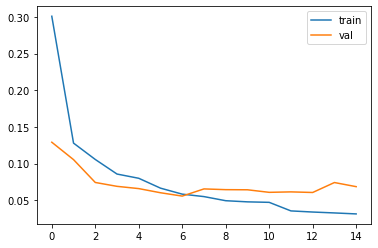

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train")
plt.plot(test_loss, label="val")
plt.legend()
plt.show()

We can then evaluate the model over the test set using the function "eval_symptom_classifier". Here, we compare the predictions of the model with the ground truth symptom labels, and calculate the precision, recall, F1 and accuracy. 

In [11]:
with open("../data/emb/df_test_emb.p", "rb") as file: 
    df_test = pickle.load(file)

symptom = "dysp"
setting = "hist" 
type = "normal"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_data = TabularTextDataset(df_test, symptom, device, setting, type)

In [12]:
from utils.neural_classifier import eval_symptom_classifier
precision, recall, f1, acc = eval_symptom_classifier(symptom, test_data, model)

In [13]:
precision, recall, f1, acc

(0.9593908629441624, 0.9473684210526315, 0.953341740226986, 0.9815)

Following the example outlined above, we trained classifiers for the symptoms dysp, cough, pain and nasal, in combination with each note type (normal or advanced) and each embedding setting (hist, phys, mean, concat). We used the same hyperparameters for all these classifiers (same as the ones used in the example). These hyperparameters were obtained using a mix of manual tuning and exhaustive grid search over the setting "mean" for the normal notes. 

For fever, we did a separate hyperparameter optimization, since we noticed that this classifier tended to collapse more easily towards the majority classes (none and low). We landed on training the fever classifiers for 30 epochs, with a learning rate of 5e-4 instead. 

Training all these models over the full training set, and evaluating them over the test set, yields the results stored in "results/neural_normal_test.p" and "results/neural_adv_test.p".

### Span embeddings 

We annotated the notes with spans of where each symptom was mentioned. To get a representation of the notes which contains only the most important information for predicting whether a symptom is present or not, we can use these spans to our advantage. Of course, in a realistic setting, it is unlikely that one would have accessed to a dataset of clinical notes that is fully annotated with spans, so this baseline should be treated as a gold standard for the text-only predictors. 

We first generate a BioLORD embedding for each span. 

In [1]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("FremyCompany/BioLORD-2023") # import the BioLORD model

c:\Users\Paloma\anaconda3\envs\transformers\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Paloma\anaconda3\envs\transformers\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [3]:
import json
with open("../data/spans/normal_span_annotations.json", "r") as file: 
    ann_normal = json.load(file)

By way of example, we generate the BioLORD embeddings for the first note. 

In [5]:
for i in ann_normal: 
    phrases = ann_normal[i]
    phrases_done = {}
    for phrase in phrases: 
        if phrase["text"] not in phrases_done: 
            phrase["emb"] = model.encode(phrase["text"], normalize_embeddings=True).tolist()
            phrases_done[phrase["text"]] = phrase["emb"]
        else: 
            phrase["emb"] = phrases_done[phrase["text"]] # avoid generating the same embedding twice
    if int(i) > 1: 
        break

In [9]:
for span in ann_normal["0"]: 
    sympt = span["symptom"]
    text = span["text"]
    emb = span["emb"][:10]
    print(f"{sympt}: {text}")
    print(f"emb: {emb}")

fever: significant increase in body temperature over the last 48 hours, exceeding normal ranges, indicating a high fever
emb: [0.05390307307243347, 0.016428271308541298, -0.03677591681480408, 0.019698454067111015, 0.00566745875403285, 0.025086641311645508, -0.029491590335965157, 0.015968531370162964, -0.034412965178489685, -0.0006697901408188045]
fever: feeling very fatigued due to the fever
emb: [0.014135751873254776, 0.012505206279456615, 0.08213531225919724, -0.015574387274682522, 0.03412409499287605, -8.686430373927578e-05, -0.04116759076714516, -0.005188985727727413, -0.050105802714824677, -0.046409644186496735]
fever: Vital signs show elevated temperature (103 °F)
emb: [0.021095838397741318, 0.020052265375852585, -0.02430410124361515, 0.016431450843811035, 0.030646374449133873, -0.011013290844857693, -0.022127388045191765, 0.05990442633628845, -0.007870732806622982, -0.0157032273709774]
fever: corresponding with the fever
emb: [-0.000666009436827153, -0.020893873646855354, 0.0107

For each symptom, we construct a span embedding by averaging the embeddings for all extracted spans that mention the symptom. When there are no spans for a certain symptom, we just take the mean embedding of the whole note (history and physical examination). 

In [10]:
import numpy as np

SYMPT_DICT = {"dysp": "dyspnea", "cough": "cough", "pain": "respiratory pain", "nasal": "nasal symptoms", "fever": "fever"}

def embed_spans(row, ann, sympt, compl): 
    i = row.name
    spans = ann[str(i)]
    embs = np.array([], dtype=np.float32).reshape(0,768)
    for span in spans: 
        if span["symptom"] == SYMPT_DICT[sympt]: 
            embs = np.vstack([embs, span["emb"]])
    if len(embs) == 0: 
        if compl == "normal": 
            return (row["hist_emb"]+row["phys_emb"])/2 # take mean of hist and phys
        else: 
            return (row["adv_hist_emb"]+row["adv_phys_emb"])/2 # take mean of hist and phys
    else:
        return np.mean(embs, axis=0)

In [ ]:
emb = embed_spans(df_train.loc[0], ann_normal, "dysp", "normal")

In [16]:
emb[:10]

array([-0.07442205,  0.01618581,  0.01255965, -0.05489065,  0.00038669,
       -0.02532689, -0.01013277,  0.02686536,  0.03667736, -0.09126137])

Such span embeddings were generated for each symptom, for both the normal and advanced notes, and stored in "data/span" folder. Each of these files contains the average span embeddings ordered by index (0 to 10000) for each combination of the symptom and note types. We can load in these embeddings as follows, after which we can train a neural classifier in the same way as we did before. 

In [20]:
import numpy as np
def load_span_embeddings(df_train, df_test, sympt, compl): 
    with open(f"../data/emb/span/{sympt}_{compl}_ann_emb.npy", "rb") as file:
        embs = np.load(file)
        
    df_train[f"{compl}_span_{sympt}"] = df_train.apply(lambda row: embs[row.name], axis=1)
    df_test[f"{compl}_span_{sympt}"] = df_test.apply(lambda row: embs[row.name], axis=1)
    
    return df_train, df_test

For example, below, we load in the embeddings for symptom dysp (normal notes), train a classifier, and evaluate over the test set. 

In [18]:
with open("../data/emb/df_train_emb.p", "rb") as file:
    df_train = pickle.load(file)
with open("../data/emb/df_test_emb.p", "rb") as file:
    df_test = pickle.load(file)

In [21]:
df_train, df_test = load_span_embeddings(df_train, df_test, "dysp", "normal")

In [26]:
from utils.neural_classifier import TabularTextDataset
import torch
from torch.utils.data import random_split 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = TabularTextDataset(df_train, "dysp", device, "span", "normal")
train_data, val_data = random_split(dataset, [0.8, 0.2])

In [27]:
from utils.neural_classifier import train_sympt_classifier

sympt = "dysp"
n_emb = 768
hidden_dim = [768, 256, 1]
dropout = 0
bs_train = 100
epochs = 15
seed = 2023
lr = 0.001
weight_decay = 1e-5

train_loss, test_loss, model = train_sympt_classifier(train_data, val_data, sympt, n_emb, hidden_dim, dropout, device, bs_train, epochs, seed, lr, weight_decay)

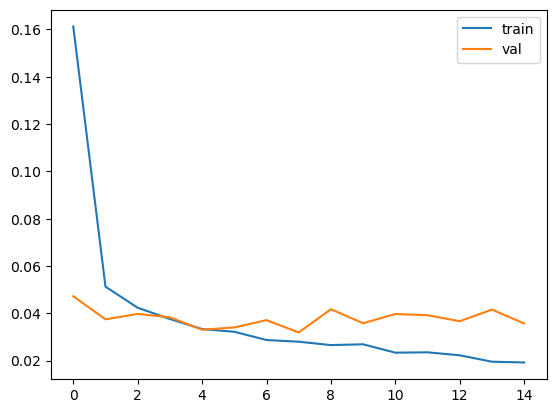

In [32]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train")
plt.plot(test_loss, label="val")
plt.legend()
plt.show()

In [33]:
symptom = "dysp"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_data = TabularTextDataset(df_test, symptom, device, "span", "normal")

In [34]:
from utils.neural_classifier import eval_symptom_classifier
precision, recall, f1, acc = eval_symptom_classifier(symptom, test_data, model)

We run such a classifier for every symptom, extending the neural-text baselines with classifiers that get to see the span embeddings at the input instead of the full text embedding. The results are added to "results/neural_normal_test.p" and "results/neural_adv_test.p" under the label "span". 

We compare the different neural-text baselines in the figure below. 

In [1]:
import pickle
with open("../results/neural_normal_test.p", "rb") as file: 
    results_normal = pickle.load(file)
with open("../results/neural_adv_test.p", "rb") as file: 
    results_adv = pickle.load(file)

In [2]:
import pandas as pd

SETTING_DICT = {"hist": "hist", "phys":"phys", "both_mean": "mean", "both_concat": "concat", "span": "span"}

def calc_mean_std(res): 
    res_mean = {}
    res_std = {}
    for emb_type in ["hist", "phys", "both_mean", "both_concat", "span"]:
        res_mean[SETTING_DICT[emb_type]] = pd.DataFrame(columns = ["precision", "recall", "f1", "accuracy"])
        res_std[SETTING_DICT[emb_type]] = pd.DataFrame(columns = ["precision", "recall", "f1", "accuracy"])
        for sympt in ["dysp", "cough", "pain", "nasal", "fever"]: 
            res_mean[SETTING_DICT[emb_type]].loc[sympt] = res[emb_type][sympt].mean()
            res_std[SETTING_DICT[emb_type]].loc[sympt] = res[emb_type][sympt].std()
    return res_mean, res_std

res_mean_normal, res_std_normal = calc_mean_std(results_normal)
res_mean_adv, res_std_adv = calc_mean_std(results_adv)

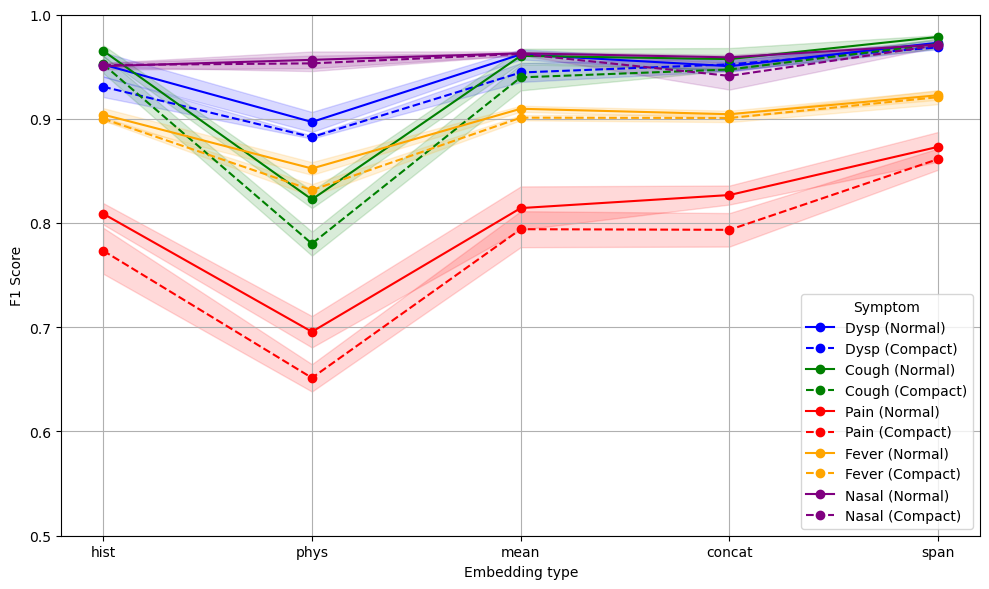

In [4]:
import matplotlib.pyplot as plt

# List of symptoms
symptoms = ["dysp", "cough", "pain", "fever", "nasal"]

# List of settings
settings = ["hist", "phys", "mean", "concat", "span"]

# Define a color map for each symptom
colors = {
    "dysp": "blue",
    "fever": "orange",
    "cough": "green",
    "pain": "red",
    "nasal": "purple"
}

# Create the plot
plt.figure(figsize=(10, 6))

# Loop over each symptom and plot the F1 scores for both sets of data
for symptom in symptoms:
    f1_scores = []
    f1_scores_adv = []
    error_bars = []
    error_bars_adv = []

    # Extract F1 scores from the original and new dataframes
    for setting in settings:
        f1_scores = [res_mean_normal[setting].loc[symptom, "f1"] for setting in settings]
        f1_scores_adv = [res_mean_adv[setting].loc[symptom, "f1"] for setting in settings]
        std_normal = [res_std_normal[setting].loc[symptom, "f1"] for setting in settings]
        std_adv = [res_std_adv[setting].loc[symptom, "f1"] for setting in settings]

        margin_normal = [1.96 * (s / (5 ** 0.5)) for s in std_normal]
        margin_adv = [1.96 * (s / (5 ** 0.5)) for s in std_adv]

    plt.plot(settings, f1_scores, marker='o', label=f'{symptom.capitalize()} (Normal)', color=colors[symptom])
    plt.fill_between(settings, 
                    [m - e for m, e in zip(f1_scores, margin_normal)], 
                    [m + e for m, e in zip(f1_scores, margin_normal)], 
                    color=colors[symptom], alpha=0.15)

    plt.plot(settings, f1_scores_adv, linestyle='--', marker='o', label=f'{symptom.capitalize()} (Compact)', color=colors[symptom])
    plt.fill_between(settings, 
                    [m - e for m, e in zip(f1_scores_adv, margin_adv)], 
                    [m + e for m, e in zip(f1_scores_adv, margin_adv)], 
                    color=colors[symptom], alpha=0.15)
        
plt.xlabel("Embedding type")
plt.ylabel("F1 Score")
plt.ylim([0.5, 1])
plt.grid(True)
plt.legend(title="Symptom", loc='lower right')
plt.tight_layout()
plt.savefig("text_classifier_emb_types.png", dpi=300, bbox_inches="tight")

plt.show()

## Neural-text-tab

We build upon the previous text-only classifier to build a classifier which also includes the tabular features at the input. To this end, we transform the tabular features into one-hot encodings, while days at home is included as a number (which we first normalize using a StandardScaler). We build this tabular feature vector for each of the 3 evidence settings (all, no_sympt, realistic), and combine them with the "mean" text embedding from the neural-text model. We do this for both the normal texts and the compact versions. 

The TabularDataset class in the "neural_classifier" module creates such a tabular dataset, provided the requested note type, note complexity and evidence setting. As an example, we create such a dataset for the dyspnea symptom, with "all" as evidence setting and using the "mean" text embedding for the normal notes.

In [47]:
import pickle
import pandas as pd

with open("../data/emb/df_train_emb_part1.p", "rb") as file: 
    df_train1 = pickle.load(file)
with open("../data/emb/df_train_emb_part2.p", "rb") as file: 
    df_train2 = pickle.load(file)

df_train = pd.concat([df_train1, df_train2]) # concatenate the two parts 

with open("../data/emb/df_test_emb.p", "rb") as file: 
    df_test = pickle.load(file)

In [16]:
from utils.neural_classifier import TabularTextDataset
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data = TabularTextDataset(df_train, "dysp", device, "both_mean", "normal", "all")

To make the test dataset, we need to reuse the one-hot encoder and standard scaler which were fit to the training data.

In [17]:
test_data = TabularTextDataset(df_test, "dysp", device, "both_mean", "normal", "all", encoder=train_data.enc, scaler=train_data.scaler)

In [18]:
print(train_data.__getitem__(0).keys()) # keys: symptom, tab, emb
print(train_data.__getitem__(0)["dysp"]) # symptom label
print(train_data.__getitem__(0)["tab"]) # encoded tabular features
print(train_data.__getitem__(0)["emb"][:10]) # first 10 positions of text embedding

dict_keys(['dysp', 'tab', 'emb'])
tensor(0.)
tensor([ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
        -0.4448])
tensor([-0.0076,  0.0331,  0.0207, -0.0011,  0.0254, -0.0134, -0.0362,  0.0096,
        -0.0117, -0.0309])


In [19]:
train_data.__getitem__(0)["emb"].shape

torch.Size([768])

In [20]:
train_data.__getitem__(0)["tab"].shape

torch.Size([17])

The shape of the tabular feature vector depends on the evidence setting and the symptom. For the dysp example above, the shape is 17 (13 binary features, 3 categories for fever, 1 number for days_at_home).

We can now train the tab-text symptom classifier in a similar fashion to how we trained the text-only symptom classifier above, setting the with_tab argument to True. We use the same hyperparameters as for the text-only symptom classifier, to allow for a fair comparison. 

In [21]:
from utils.neural_classifier import train_sympt_classifier

sympt = "dysp"
n_emb = 768 + 17
hidden_dim = [n_emb, 256, 1]
dropout = 0
bs_train = 100
epochs = 15
seed = 2023
lr = 0.001
weight_decay = 1e-5

train_loss, test_loss, model = train_sympt_classifier(train_data, test_data, sympt, n_emb, hidden_dim, dropout, device, bs_train, epochs, seed, lr, weight_decay, with_tab=True)

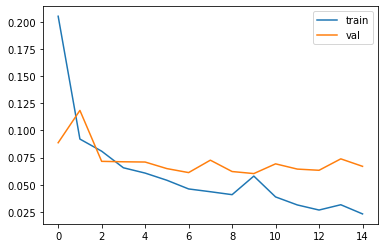

In [22]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train")
plt.plot(test_loss, label="val")
plt.legend()
plt.show()

As before, we evaluate the model over the test set, now setting the with_tab argument to True.

In [23]:
from utils.neural_classifier import eval_symptom_classifier
symptom = "dysp"
precision, recall, f1, acc = eval_symptom_classifier(symptom, test_data, model, with_tab=True)

Training all the models (all symptoms, combined with all evidence settings) over the full training set, and evaluating them over the test set, yields the results stored in "results/neural_tab_normal_test.p" and "results/neural_tab_adv_test.p". We plot the results below.

In [90]:
import pickle
with open("../results/neural_tab_normal_test.p", "rb") as file: 
    results_normal = pickle.load(file)
with open("../results/neural_tab_adv_test.p", "rb") as file: 
    results_adv = pickle.load(file)

In [91]:
import pandas as pd

def calc_mean_std(res): 
    res_mean = {}
    res_std = {}
    for feat_setting in ["all", "no_sympt", "realistic"]:
        res_mean[feat_setting] = pd.DataFrame(columns = ["precision", "recall", "f1", "accuracy"])
        res_std[feat_setting] = pd.DataFrame(columns = ["precision", "recall", "f1", "accuracy"])
        for sympt in ["dysp", "cough", "pain", "nasal", "fever"]: 
            res_mean[feat_setting].loc[sympt] = res[feat_setting][sympt].mean()
            res_std[feat_setting].loc[sympt] = res[feat_setting][sympt].std()
    return res_mean, res_std

res_mean_normal, res_std_normal = calc_mean_std(results_normal)
res_mean_adv, res_std_adv = calc_mean_std(results_adv)

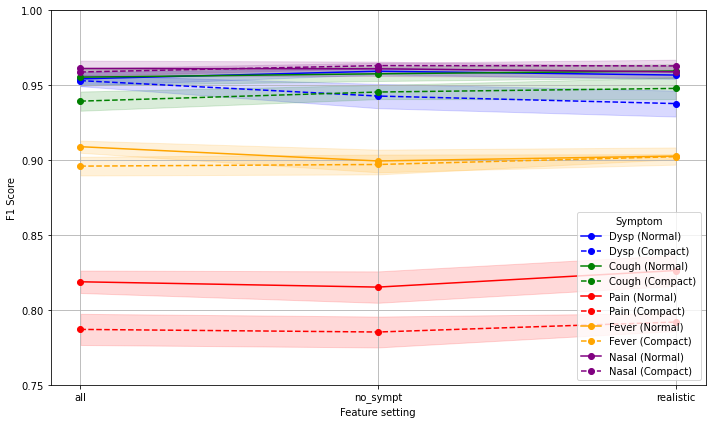

In [92]:
import matplotlib.pyplot as plt

# List of symptoms
symptoms = ["dysp", "cough", "pain", "fever", "nasal"]

# List of settings
settings = ["all", "no_sympt", "realistic"]

# Define a color map for each symptom
colors = {
    "dysp": "blue",
    "fever": "orange",
    "cough": "green",
    "pain": "red",
    "nasal": "purple"
}

# Create the plot
plt.figure(figsize=(10, 6))

# Loop over each symptom and plot the F1 scores for both sets of data
for symptom in symptoms:
    f1_scores = []
    f1_scores_adv = []
    error_bars = []
    error_bars_adv = []

    # Extract F1 scores from the original and new dataframes
    for setting in settings:
        f1_scores = [res_mean_normal[setting].loc[symptom, "f1"] for setting in settings]
        f1_scores_adv = [res_mean_adv[setting].loc[symptom, "f1"] for setting in settings]
        std_normal = [res_std_normal[setting].loc[symptom, "f1"] for setting in settings]
        std_adv = [res_std_adv[setting].loc[symptom, "f1"] for setting in settings]

        margin_normal = [1.96 * (s / (5 ** 0.5)) for s in std_normal]
        margin_adv = [1.96 * (s / (5 ** 0.5)) for s in std_adv]

    plt.plot(settings, f1_scores, marker='o', label=f'{symptom.capitalize()} (Normal)', color=colors[symptom])
    plt.fill_between(settings, 
                    [m - e for m, e in zip(f1_scores, margin_normal)], 
                    [m + e for m, e in zip(f1_scores, margin_normal)], 
                    color=colors[symptom], alpha=0.15)

    plt.plot(settings, f1_scores_adv, linestyle='--', marker='o', label=f'{symptom.capitalize()} (Compact)', color=colors[symptom])
    plt.fill_between(settings, 
                    [m - e for m, e in zip(f1_scores_adv, margin_adv)], 
                    [m + e for m, e in zip(f1_scores_adv, margin_adv)], 
                    color=colors[symptom], alpha=0.15)
        
plt.xlabel("Feature setting")
plt.ylabel("F1 Score")
plt.ylim([0.75, 1])
plt.grid(True)
plt.legend(title="Symptom", loc='lower right')
plt.tight_layout()

plt.show()